## This code is for copy-paste augmentation used for yolo detection networks

Usage: The detection networks have been well trained on public datsets such as coco. If we want to add new classes to the pretrianed network but with limited labeled samples, we can use this copy-paste methods to create more samples to improve the accuracy on the new classes.

In [1]:
import os
import cv2
from torchvision.datasets import CocoDetection
import random
import numpy as np
import matplotlib.pyplot as plt

# Read the new classes in the coco labeling format (better with segmentation annotations, 
# this tutorail is based on the segmentation, but can be easily adapted to detection annotations)

def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

def has_valid_annotation(anno):
    if len(anno) == 0:
        return False
    if _has_only_empty_bbox(anno):
        return False
    if "keypoints" not in anno[0]:
        return True
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True

    return False

class CocoDetectionCP(CocoDetection):
    def __init__(
        self,
        root,
        annFile,
        transforms
    ):
        super(CocoDetectionCP, self).__init__(
            root, annFile, None, None, transforms
        )

        # filter images without detection annotations
        ids = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anno = self.coco.loadAnns(ann_ids)
            if has_valid_annotation(anno):
                ids.append(img_id)
        self.ids = ids

    def load_example(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        target = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs(img_id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        masks = []
        bboxes = []
        for ix, obj in enumerate(target):
            try:
                masks.append(self.coco.annToMask(obj))
                bboxes.append(obj['bbox'] + [obj['category_id']] + [ix])
            except IndexError:
                print('error when reading')
                
        if bboxes!= []:
        #pack outputs into a dict
            output = {
                'image': image,
                'masks': masks,
                'bboxes': bboxes
            }

            return output

In [3]:
data = CocoDetectionCP(
'wheelchari_segment_coco/train',
'wheelchari_segment_coco/train/_annotations.coco.json',
    None
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
def extract_forground(img_logo):
    img2gray = cv2.cvtColor(img_logo,cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, 175, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    mask = np.uint8(mask)
    img1_bg = cv2.bitwise_and(img_logo, img_logo, mask=mask)
    img2_fg = cv2.bitwise_and(img_logo, img_logo, mask = mask_inv)
    return img2_fg

def generate_iamge(background_image,background_label,output_label,output_image,write=0,show=1):
    chair_index  = random.randint(2,450) 
    reshape_size =  random.randint(200,400)
    x = data.load_example(chair_index)
    if x == None:
        pass
    else:
        y = x['masks'][0].reshape(640,640,1)
        image = x['image']
        original_shape = image.shape
        se_image = image*y
        label = x['bboxes'][0]
        xx,yy,ww,hh = label[0],label[1],label[2],label[3]
        new_label = label

        se_image = cv2.resize(se_image,(reshape_size,reshape_size))
        se_image = extract_forground(se_image)
        y        = cv2.resize(y,(reshape_size,reshape_size)).reshape(reshape_size,reshape_size,1)

        new_label[2] = label[2]*reshape_size/original_shape[0]
        new_label[3] = label[3]*reshape_size/original_shape[1]


        original = cv2.resize(background_image,(640,640))

        image_large = original
        image_small = se_image

        x_position = random.randint(0, image_large.shape[1] - image_small.shape[1])
        y_position = random.randint(0, image_large.shape[0] - image_small.shape[0])

        new_label[0] = label[0]+x_position*reshape_size/original_shape[0]
        new_label[1] = label[1]+y_position*reshape_size/original_shape[1]

        roi = image_large[y_position:y_position + image_small.shape[0], x_position:x_position + image_small.shape[1]]

        roi_new = roi*(1-y)


        result = cv2.addWeighted(roi_new, 1, image_small, 1, 0)

        zero_pixels = (result == 0)

        result[zero_pixels] = roi[zero_pixels]

        image_large[y_position:y_position + image_small.shape[0], x_position:x_position + image_small.shape[1]] = result

        if show==1:
            plt.subplot(1,2,1)
            plt.imshow(image_large)
            plt.subplot(1,2,2)
            plt.imshow(image_large[int(y_position+yy/640*reshape_size):int(y_position+yy/640*reshape_size+hh/640*reshape_size),int(x_position+xx/640*reshape_size):int(x_position+xx/640*reshape_size+ww/640*reshape_size)
                               ])


        new_w = hh/640*reshape_size/640
        new_h = hh/640*reshape_size/640
        
        new_x = int((x_position+xx/640*reshape_size)+new_w/2*640)/640
        new_y = int((y_position+yy/640*reshape_size)+new_h/2*640)/640

        if write:
            new_label =[80,new_x,new_y,new_w,new_h]
            background_label.append(new_label)
           # write image
            cv2.imwrite(output_image,cv2.cvtColor(image_large, cv2.COLOR_RGB2BGR))

        # Write the numbers to the file, separated by space

            with open(output_label, 'w') as file:
                # Write each element of the list to a new line in the file
                for item in background_label:
                    file.write(' '.join(map(str, item))+'\n')
        
def read_yolo_labels(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    labels = []
    for line in lines:
        data = line.strip().split()
        if len(data) >= 5: 
            class_id = int(data[0])
            bbox = list(map(float, data[1:]))
            labels.append([class_id] + bbox)

    return labels

def draw_bounding_boxes(image, labels, colors):
    h, w, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, box_width, box_height = label
        # Convert normalized coordinates to pixel coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)

        # Draw rectangle
        color = colors[class_id]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Put class ID
        label_text = f"{class_id}"
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

In [28]:
import os
import random
import cv2
from tqdm import tqdm

# Paths
coco_image_path = 'coco128/images/train2017'
coco_label_path = 'coco128/labels/train2017'

output_image_dir = 'samples/images/train2017'
output_label_dir = 'samples/labels/train2017'

# Ensure output directories exist
if not os.path.exists(output_image_dir):
    os.makedirs(output_image_dir)

if not os.path.exists(output_label_dir):
    os.makedirs(output_label_dir)

# Get list of images
image_list = os.listdir(coco_image_path)

# Use tqdm for progress bar
for i in tqdm(range(20), desc="Generating Images"):
    random_index = random.randint(0, len(image_list) - 1)  # Adjusted to avoid IndexError
    image_name = image_list[random_index]

    image_path = os.path.join(coco_image_path, image_name)
    label_path = os.path.join(coco_label_path, image_name[:-4] + '.txt')

    if os.path.exists(label_path):
        label = read_yolo_labels(label_path)  # Assumes this function is defined elsewhere
        output_image_path = os.path.join(output_image_dir, image_name)
        output_label_path = os.path.join(output_label_dir, image_name[:-4] + '.txt')

        original = cv2.imread(image_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        generate_iamge(original, label, output_label_path, output_image_path, 1, 0)  # Assumes this function is defined elsewhere



Generating Images: 100%|███████████████████████| 20/20 [00:00<00:00, 156.33it/s]


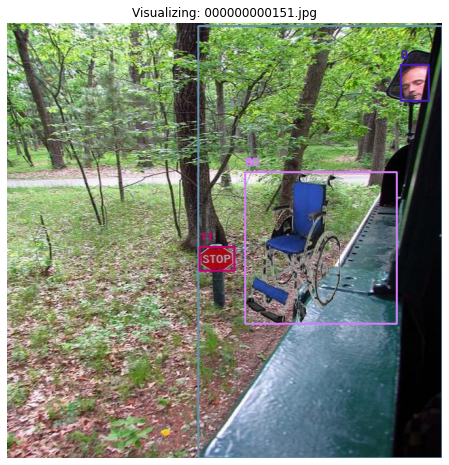

In [43]:
image_dir = "samples/images/train2017"
label_dir = "samples/labels/train2017"

# Get a random image and corresponding label
image_list = os.listdir(image_dir)
random_image = random.choice(image_list)
image_path = os.path.join(image_dir, random_image)
label_path = os.path.join(label_dir, random_image.replace('.jpg', '.txt'))

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Check if the corresponding label file exists
if os.path.exists(label_path):
    labels = read_yolo_labels(label_path)
    num_classes = 86  # Update this to the number of classes in your dataset
    colors = [tuple(random.randint(0, 255) for _ in range(3)) for _ in range(num_classes)]
    output_image = draw_bounding_boxes(image, labels, colors)
    

    # Display the image with bounding boxes
    plt.figure(figsize=(12, 8))  # Adjust figure size
    plt.imshow(output_image)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Visualizing: {random_image}")
    plt.show()
else:
    print(f"Label file not found for {random_image}")
